# Projet d'Analyse de Données : Prédiction du prix de Airbnb

## Introduction

Ce projet a pour objectif d'exposer une démarche complète sur un jeu de données allant de l'exploration à la modélisation de données réelles.

Le projet consiste à prédire le **logarithme du prix** d'un logement Airbnb à partir de ses caractéristiques données depuis un document csv.  
Cela implique plusieurs étapes : 
- **Explorer et comprendre** les données disponibles,
- **Nettoyer** et **prétraiter** ces données pour les rendre exploitables,
- **Créer de nouvelles caractéristiques** pertinentes pour la prédiction,
- **Construire et évaluer des modèles prédictifs**.

Nous allons suivre une démarche rigoureuse, en expliquant **pourquoi** nous réalisons chaque étape, **comment** elle est mise en œuvre, et **quelles conclusions** nous pouvons en tirer pour chaque é.

Notre objectif n'est pas seulement d'obtenir la meilleure performance possible, mais surtout de montrer une analyse critique et structurée de notre approche.

---


## Exploration des données initiales 

In [4]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliothèque de la partie modélisation 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.decomposition import PCA

#### Commençons par charger le jeu de données

In [6]:
Donnee_Train = pd.read_csv("airbnb_train.csv")

In [7]:
dimensions = Donnee_Train.shape
types = Donnee_Train.dtypes.value_counts()

print("Dimensions :", dimensions)
print("\nTypes:\n", types)

Dimensions : (22234, 28)

Types:
 object     17
float64     7
int64       3
bool        1
Name: count, dtype: int64


On a donc 17 données qualitatives, 10 quantitatives et 1 booléenne. 

### Présentation rapide du dataset

Nous disposons de **22234 enregistrements** et de **28 variables** décrivant les logements.

Avant de pouvoir effectuer une prédiction fiable, il est nécessaire de comprendre la nature de ces données :
- Quels types de variables sont présentes (quantitatives, qualitatives) ?
- Si il y a des valeurs manquantes ?
- Quelles sont les variables qui semblent les plus liées au prix ?
  
### Valeurs manquantes
Nous allons désormais regarder si il y a des valeurs manquantes dans nos données.

Cela permet d’identifier :
- Les colonnes problématiques
- La proportion d’informations absentes
- Les stratégies à envisager lors du preporcessing.

Nous allons donc visualiser quelles colonnes contiennent des données manquantes et à quelle fréquence afin de pouvoir voir si il y a des données à corriger pour le compléter par la suite.

In [10]:
manquantes = Donnee_Train.isnull().sum()
manquante_p = (manquantes / len(Donnee_Train) * 100)


manquante_f = manquante_p[manquante_p > 0].sort_values(ascending=False)

manquante_data = pd.DataFrame({
    'Colonne': manquante_f.index,
    'Pourcentage de valeurs manquantes': manquante_f.values.round(1)
})

print(manquante_data)

                   Colonne  Pourcentage de valeurs manquantes
0       host_response_rate                               24.6
1     review_scores_rating                               22.4
2             first_review                               21.3
3              last_review                               21.2
4            neighbourhood                                9.4
5                  zipcode                                1.4
6     host_has_profile_pic                                0.3
7   host_identity_verified                                0.3
8               host_since                                0.3
9                bathrooms                                0.2
10                    beds                                0.2
11                bedrooms                                0.1


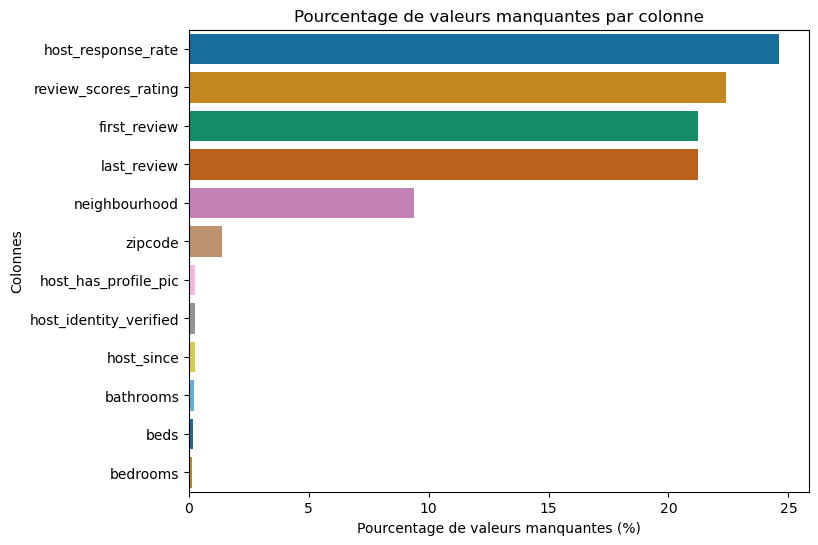

In [68]:
# calcul des valeurs manquantes en pourcentage
valeurs_manquantes = Donnee_Train.isnull().sum() / len(Donnee_Train) * 100

# il faut que on garde que les colonnes avec des valeurs manquantes
valeurs_manquantes = valeurs_manquantes[valeurs_manquantes > 0].sort_values(ascending=False)

#print(valeurs_manquantes)

plt.figure(figsize=(8, 6))
sns.barplot(x=valeurs_manquantes, y=valeurs_manquantes.index, hue=valeurs_manquantes.index,dodge=False, palette="colorblind", legend=False)
plt.xlabel('Pourcentage de valeurs manquantes (%)')
plt.ylabel('Colonnes')
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.show()

### Observations

En regardant les valeurs manquantes, on remarque que certaines colonnes comme `host_response_rate`, `review_scores_rating`, ou encore `first_review` et `last_review` ont plus de 20 % de données absentes. D'autres colonnes comme `neighbourhood` ou `zipcode` sont également concernées mais dans une moindre mesure.

Plutôt que de supprimer directement ces colonnes et risquer de perdre des informations potentiellement utiles pour la prédiction, nous comptons les conserver en appliquant des stratégies adaptées que nous avons trouvées sur internet ou en cherchant dans des cours.  
Par exemple, nous pourrons utiliser **l'imputation par la moyenne** ou **la médiane** pour les variables numériques comme les `notes`, remplacer certaines dates manquantes par une valeur spéciale, ou encore créer de nouvelles variables, comme l'**ancienneté d’une annonce** à partir de `host_since`.

Concernant les colonnes numériques telles que `bathrooms`, `bedrooms` ou `beds`, le pourcentage de données manquantes est très faible, ce qui nous permettra de les compléter facilement avec des **valeurs centrales** sans trop altérer la qualité du dataset.

Globalement, le dataset est relativement propre et nous allons pouvoir exploiter la majorité des informations disponibles sans avoir besoin d'inventer ou de remplir massivement avec des "fausses" valeurs, ce qui est un point positif pour la suite de l’analyse.


## Visualisation de la variable cible

Avant de passer aux prédictions, on a commencé par jeter un œil à la variable qu’on cherche à prédire : `log_price`.  
Comme son nom l’indique, il s’agit du **logarithme du prix** des logements. Cette transformation est souvent utilisée pour réduire l’effet des valeurs extrêmes (les logements très chers, par exemple) et pour rendre la distribution plus "normale", ce qui est souvent préférable pour entraîner des modèles de régression.

L’idée ici, c’est de voir à quoi ressemble sa distribution et surtout voir si l’utilisation du log a bien permis de lisser les données.

C’est une étape importante car cela nous donne une première idée de la répartition des prix et de comment nos futurs modèles risquent de se comporter.

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(Donnee_Train['log_price'], bins=50, kde=True, color='pink')
plt.title('Distribution de la variable cible : log_price')
plt.xlabel('log_price')
plt.ylabel('Fréquence')
plt.show()

La distribution du logarithme du prix présente une forme proche d'une loi normale, centrée entre 4.5 et 5.  
Cette répartition des prix est raisonnable et ne présente rien d'aberrant.  
Les différents pics de fréquence visibles sur l’histogramme traduisent une certaine "naturalité" dans la distribution des prix, sans anomalie majeure.

In [15]:
Donnee_Train['log_price'].describe()

count    22234.000000
mean         4.783481
std          0.718758
min          2.302585
25%          4.317488
50%          4.700480
75%          5.220356
max          7.600402
Name: log_price, dtype: float64

La variable `log_price` correspond au logarithme du prix des logements. Quand on regarde sa distribution, elle est plutôt bien répartie et assez symétrique.

En moyenne, le `log_price` tourne autour de **4.78**, ce qui correspond à un prix d’environ **120 €**.  
Les valeurs s'étendent entre des extrêmes allant de **2.30** (soit environ **10 €**) jusqu’à **7.60** (environ **2000 €**).

Nous remarquons aussi que la moitié des logements ont un prix en dessous de **4.70** en log, ce qui correspond à moins de **110 €**.  
On observe donc une médiane légèrement inférieure à la moyenne.

## Variables numeriques et variable cible, que pouvons nous dire? 

Pour débuter réellement l'exploration des données nous allons tout d'abord tracer une heat map de correlation entre les données quantitatives car elles n'ont pas besoin d'être traiter. Ce premier jet sur le jeu va permettre de révelé une coralation ou non entre les donnée. Elle est très utile et intuitive à lire.

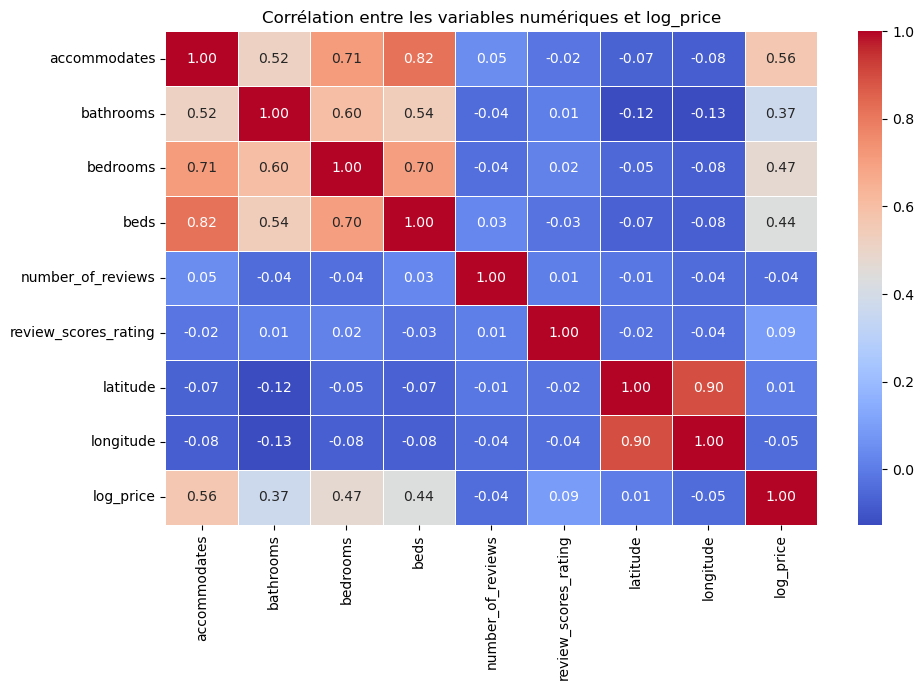

In [20]:
colonnes_numeriques = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 
                       'number_of_reviews', 'review_scores_rating', 
                       'latitude', 'longitude', 'log_price']

matrice_correlation = Donnee_Train[colonnes_numeriques].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(matrice_correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Corrélation entre les variables numériques et log_price")
plt.tight_layout()
plt.show()

On observe que certaines variables comme le nombre de personnes acceptées (accommodates), les salles de bain, les chambres ou les lits sont bien corrélées avec le prix. Ce n’est pas trop surprenant : plus un logement est grand, plus il coûte cher. D’autres variables comme la latitude ou le nombre d’avis sont moins corrélées, mais on les garde au cas où elles apportent quelque chose plus tard lors du traitement des colonnes.

## Analyse du prix en fonction d'autres variables.

Nous allons donc nous interesser a la relation entre la variable `log_price` et d'autre varibles pour voir comment elles se repartissent et leur lien de proportionnalité si on peut si il est évident. Nous allons en premier lieu faire cette analyse avec les variable corrélé aux prix comme `accommodates`, `bathrooms` et `beds`.

Commençons avec `accommodates` !

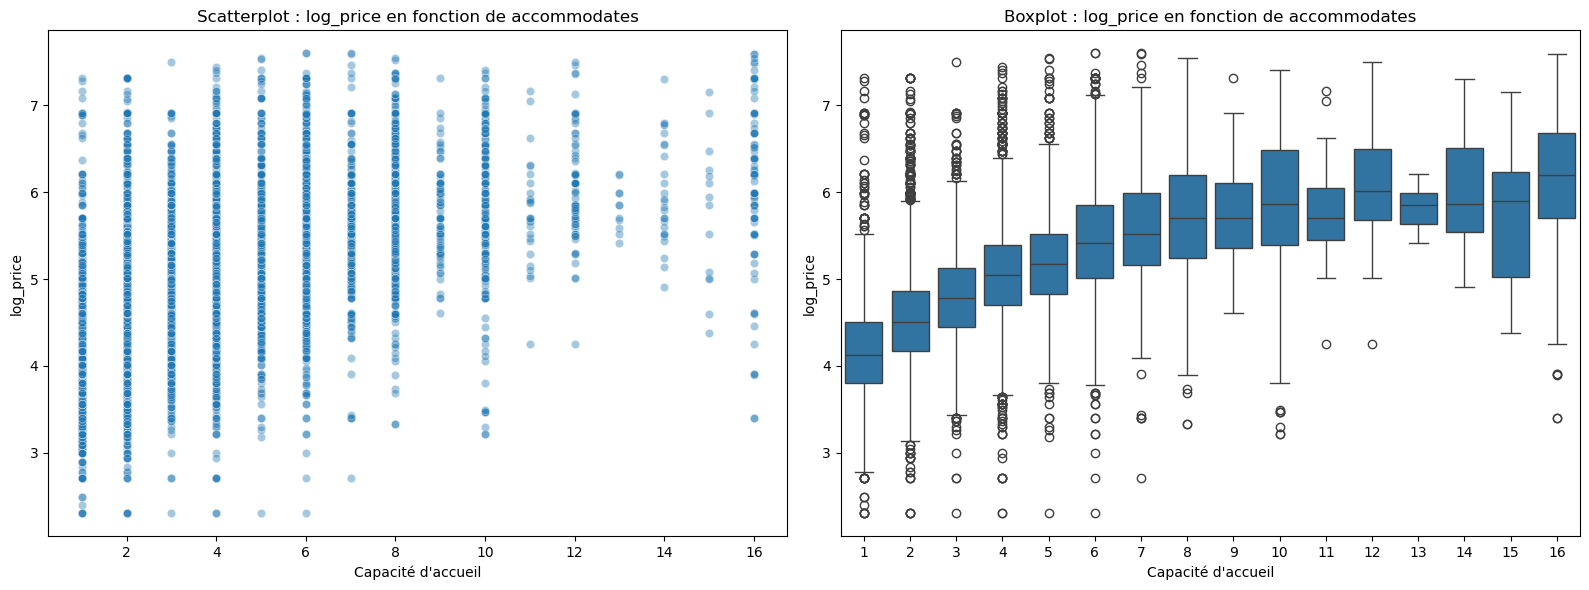

In [24]:
# Affichage côte à côte : Scatterplot vs Boxplot

plt.figure(figsize=(16, 6))

# Scatterplot
plt.subplot(1, 2, 1)
sns.scatterplot(data=Donnee_Train, x='accommodates', y='log_price', alpha=0.4)
plt.title('Scatterplot : log_price en fonction de accommodates')
plt.xlabel('Capacité d\'accueil')
plt.ylabel('log_price')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x='accommodates', y='log_price', data=Donnee_Train)
plt.title('Boxplot : log_price en fonction de accommodates')
plt.xlabel('Capacité d\'accueil')
plt.ylabel('log_price')

plt.tight_layout()
plt.show()

De part la difficulté de lecture du scatterplot, nous avons preferé faire un diagram moustache (boxplot). Les boites "petites" indiquent un prix plus concentré par rapport a la capacité d'acceuil, alors que les boites "larges" indique des prix plus étalé. On voit bien que plus un logement peut accueillir de monde, plus la moyenne prix a tendance à augmenter et ceux de manière exponentiel. Par contre, à partir de 6-8 personnes, les prix deviennent plus dispersés. 

Nous allons maintenant regarder le lien entre `log_price` et la moyenne des avis `review_scores_rating`.

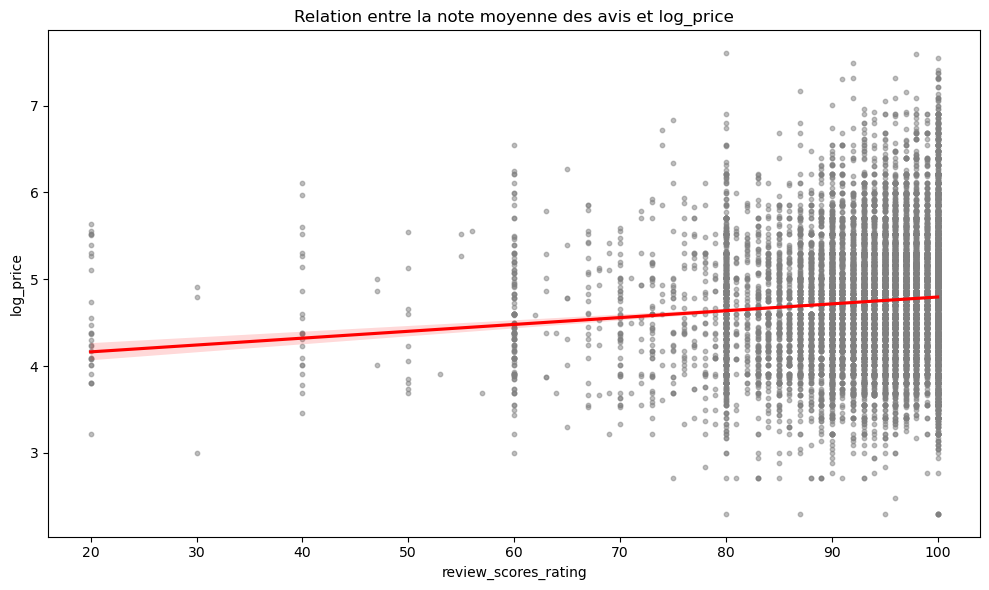

In [49]:
plt.figure(figsize=(10,6))
sns.regplot(data=Donnee_Train,x='review_scores_rating', y='log_price',
 scatter_kws={'alpha': 0.5, 'color': 'grey', 's': 10, 'marker': '.'},
    line_kws={'color': 'red'})

plt.title('Relation entre la note moyenne des avis et log_price')
#plt.xlabel('Note moyenne des avis')
#plt.ylabel('log_price')
plt.tight_layout()
plt.show()

 Nous avons decider d'affichr la courbe de la regression lineaire en plus des points car le scatterplot uniquement etait difficilement lisible.On observe une légère tendance indiquant que les logements mieux notés sont en moyenne un peu plus chers, mais cela ne represente pas une augmentation très importante. En effet, la pente de la droite de régression est **positive**, mais reste **très faible**, ce qui montre que la note moyenne des avis n'a pas un impact très important à elle seule sur le prix.

Cela reste néanmoins une information intéressante à garder, car il est possible qu’en combinaison avec d’autres variables (comme la localisation, le type de logement, etc.), cette note puisse jouer un rôle plus important.

Enfin, nous allons regarder le prix avec les deux variables du nombre de chambres `bedrooms` et de salles de bains `bathrooms`, on va donc repartir ces prix par des bulles plus ou moins grosses.

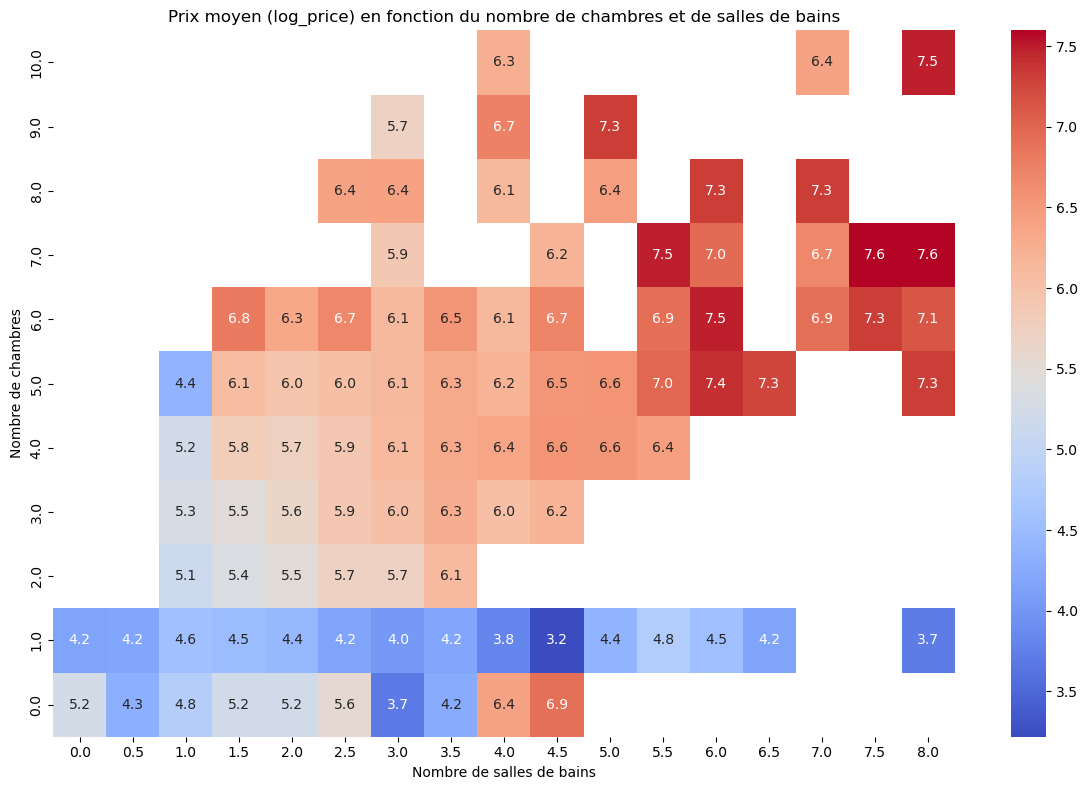

In [59]:
# Créer une table croisée pour la moyenne des prix
pivot = Donnee_Train.pivot_table(
    index='bedrooms',
    columns='bathrooms',
    values='log_price',
    aggfunc='mean'
)

# Affichage de la heatmap
plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Prix moyen (log_price) en fonction du nombre de chambres et de salles de bains')
plt.xlabel('Nombre de salles de bains')
plt.ylabel('Nombre de chambres')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Ici le resulat est sans appel on remarque bien que la temperature de la heatmap augmente lorsque on se déplace vers le haut en gauche de la map. Le prix augmente donc bien de maniere proportionel lorsque le nombre de salles de bains et/ou de hambres augmente.

### Passons aux variables catégorielles (qualitatives)

Le but maintenant est de regarder la repartition des variables qualtitatives, si elles se repettent et sont  arbitraire commme un avis ou si elles sont choisis parmis des propostions comme le type de logement. Cette partie de l'exploration va nous permettre d'obtenir des informations utiles pour la parties du préprocessing. 

Nous allons commencer par le `room_type` voir sa répartition et son lien avec le prix.

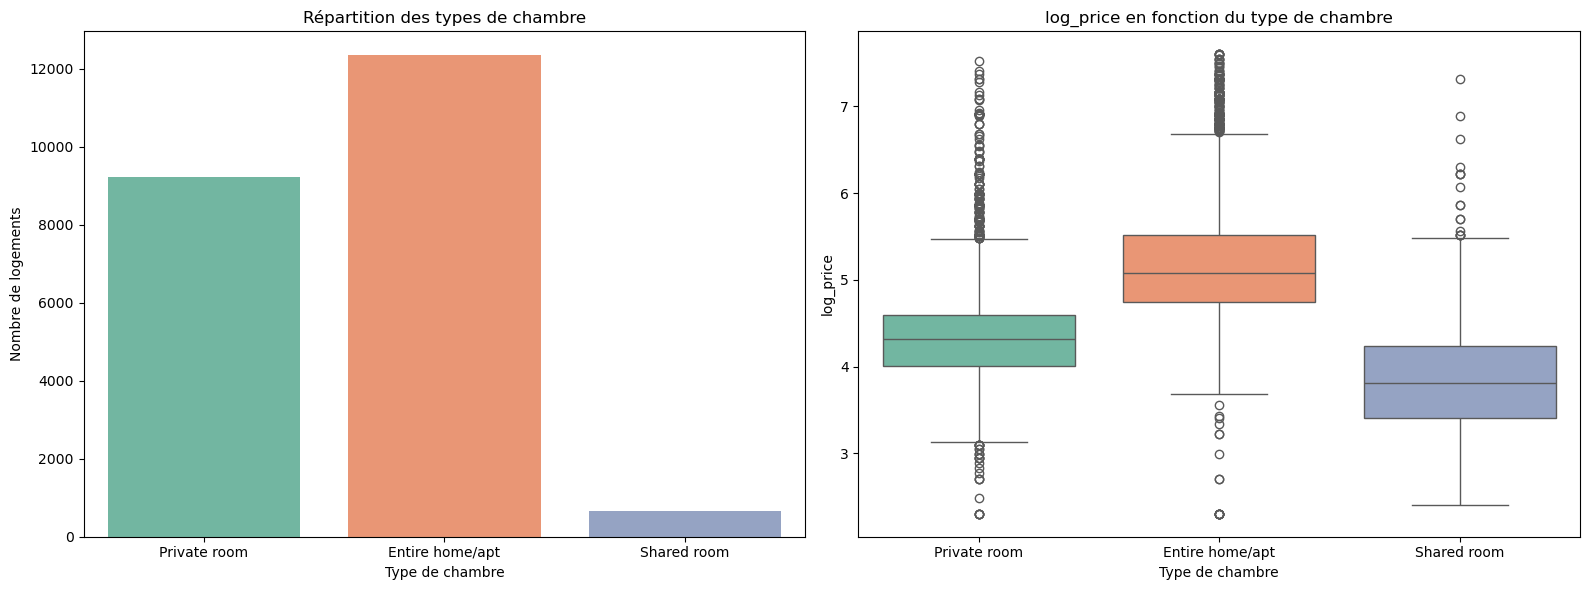

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Countplot du type de chambre 
sns.countplot(
    data=Donnee_Train,
    x='room_type',
    hue='room_type',
    palette='Set2',
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Répartition des types de chambre")
axes[0].set_xlabel("Type de chambre")
axes[0].set_ylabel("Nombre de logements")

# Boxplot du prix en fonction du type de chambre
sns.boxplot(
    data=Donnee_Train,
    x='room_type',
    hue='room_type',
    legend=False,
    y='log_price',
    palette='Set2',
    ax=axes[1]
)
axes[1].set_title("log_price en fonction du type de chambre")
axes[1].set_xlabel("Type de chambre")
axes[1].set_ylabel("log_price")

plt.tight_layout()
plt.show()

On voit que la majorité des logements sont des appartements ou maisons entiers (Entire home/apt). Ensuite viennent les chambres privées, puis les chambres partagées qui elles sont très rares.

Pour le prix, c’est assez clair : les logements entiers (appartement ou maison) sont les plus cher  ce qui est logique pour une plateforme comme AirBnBe, on retrouve après les chambres privées. Les chambres partagées quant à elles sont nettement moins chères.
Cette variable a donc clairement un impact sur le prix et sera très utile pour la prédiction.

Nous allons regarder la repartition pour `property_type` ? Pour cela nous allons faire les memes graphiques car c'est le plus simpke et intuitif a comprendre nous allons par contre selectionner les 10 types les plus frequent par soucis de lisibilité.

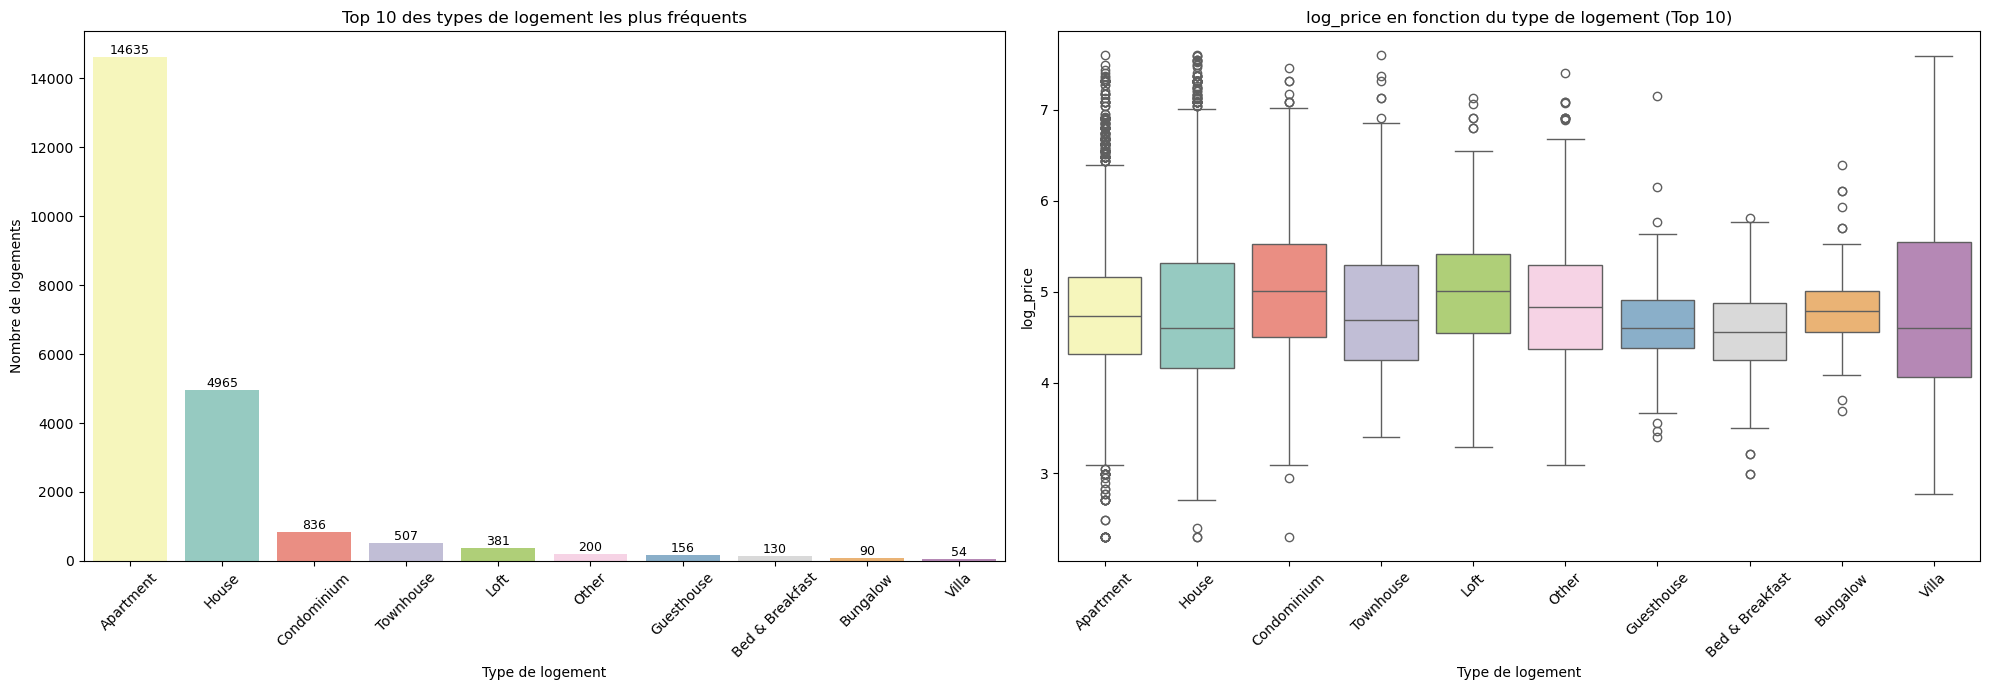

In [98]:
# Sélection des 10 types de logement les plus fréquents
top_property_types = Donnee_Train['property_type'].value_counts().head(10).index
filtered_df = Donnee_Train[Donnee_Train['property_type'].isin(top_property_types)]

# Affichage côte à côte : countplot + boxplot
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Countplot
sns.countplot(data=filtered_df,x='property_type',hue='property_type',order=top_property_types,palette='Set3',legend=False,ax=axes[0])
axes[0].set_title("Top 10 des types de logement les plus fréquents")
axes[0].set_xlabel("Type de logement")
axes[0].set_ylabel("Nombre de logements")
axes[0].tick_params(axis='x', rotation=45)  # Rotation des labels x pour lisibilité

for container in axes[0].containers:
    axes[0].bar_label(container, label_type='edge', fontsize=9)

# Boxplot
sns.boxplot(data=filtered_df,x='property_type',hue='property_type',y='log_price',order=top_property_types,palette='Set3',legend=False,ax=axes[1])
axes[1].set_title("log_price en fonction du type de logement (Top 10)")
axes[1].set_xlabel("Type de logement")
axes[1].set_ylabel("log_price")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Les deux graphiques sont tous deux révélateurs, même si le second est moins pertinent. Il montre la difficulté d'établir une relation précise entre le type de logement et son prix, car les prix sont très étalés et présentent de nombreuses valeurs extrêmes.

Le premier graphique, en revanche, nous montre que le nombre **d'appartement** parmi les locations est extrêmement conséquent, et que **les maisons** ne sont pas négligeables** non plus.  
Cependant, les autres types de logements ne représentent qu'une infime partie du jeu de données.

Cela nous donne donc un indice précieux pour le **prétraitement**  (preprocessing) :  
nous pourrons envisager de regrouper les types de logement en créant une nouvelle colonne avec trois catégories principales :
- Appartements,
- Maisons,
- Autres types regroupés ensemble.

Regardons à present la `Cancelation_policy` sa répartition et son impact face au prix des logements. Pour mieux lire les politique nous avons decider de regrouper toutes les politiques rares dans une seule catégorie. Nous afficherons ensuite la répartition du prix par rapport à ces politiques à l'aide d'un diagramme violon.

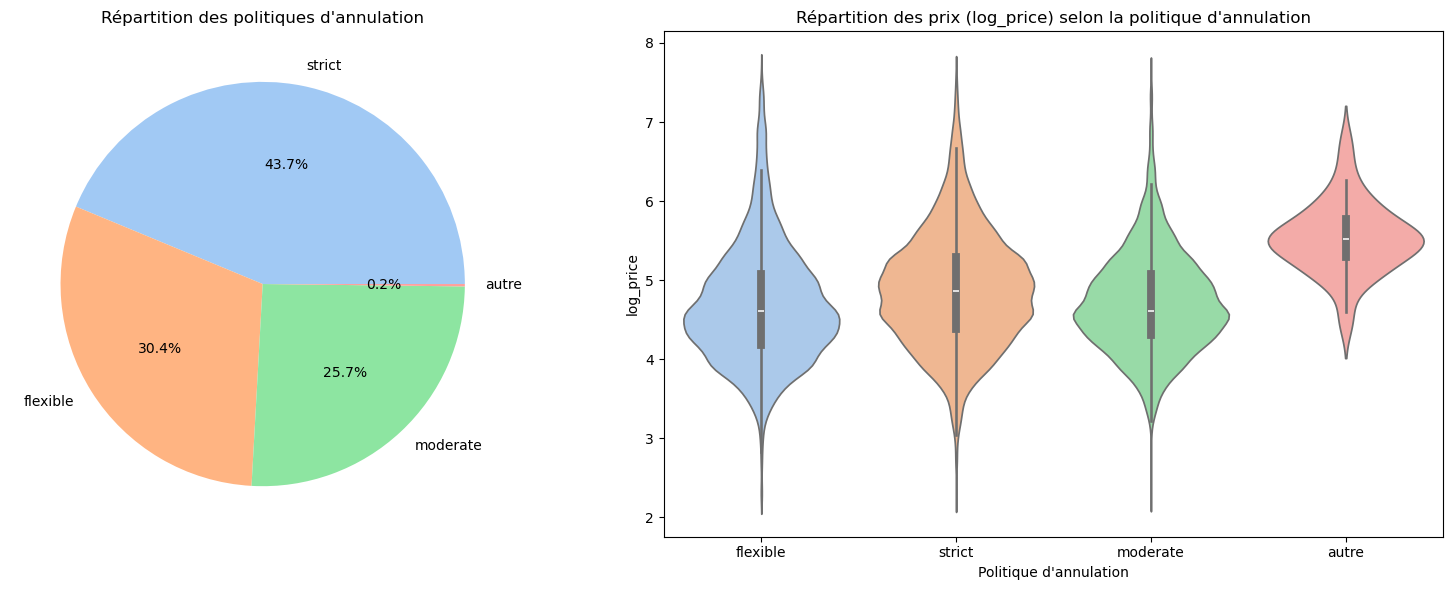

In [112]:
# Simplification de la politique d'annulation
Donnee_Train['cancellation_policy_simplifié'] = Donnee_Train['cancellation_policy'].replace({
    'super_strict_30': 'autre',
    'super_strict_60': 'autre'
})
# Ici on a regroupé les politiques très rares pour un graphique plus lisible.

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphe 1 : Camembert des politiques d'annulation
Donnee_Train['cancellation_policy_simplifié'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel'),
    ax=axes[0]
)
axes[0].set_title("Répartition des politiques d'annulation")
axes[0].set_ylabel("")  # Supprimer le label y pour le pie chart

# Graphe 2 : Violin plot du prix selon la politique
sns.violinplot(data=Donnee_Train,x='cancellation_policy_simplifié', hue='cancellation_policy_simplifié',y='log_price',palette='pastel', legend=False,ax=axes[1])
axes[1].set_title("Répartition des prix (log_price) selon la politique d'annulation")
axes[1].set_xlabel("Politique d'annulation")
axes[1].set_ylabel("log_price")

plt.tight_layout()
plt.show()


pour la majorité des logement une politique "strict" ou "flexible" est utilisé , suivie de "moderate" avec un peu moins de bien . Les politiques très strictes (super_strict_30 et 60) sont ultra rares, donc on les a regroupées dans une catégorie "autre".

Quand on regarde les prix, on remarque que les logements avec une politique plus souple (comme "flexible") sont en moyenne un peu moins chers que ceux avec une politique stricte. Mais globalement, les écarts ne sont pas énormes et les "violons" se ressemble et s'elargisse de la meme maniere globalement ce qui montre que la repartition se fait globalement de la même manière. 
On conclue que cette variable n'est pas pertinente pour la suite. 

Continuons avec la derniere variable catégorielle : "instant_bookable" qui est la seule variable boolenne du jeu

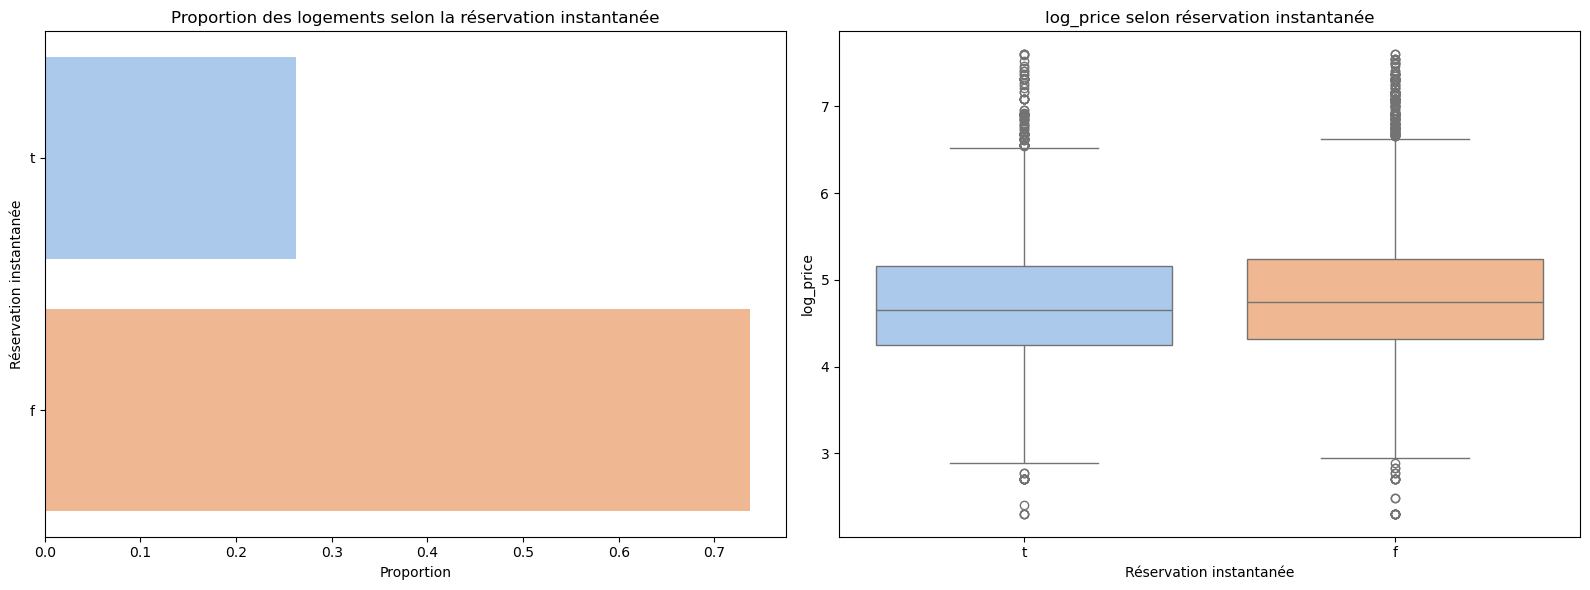

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1er graphique : Proportion réservation instantanée
instant_counts = Donnee_Train['instant_bookable'].value_counts(normalize=True).sort_values()

sns.barplot(x=instant_counts.values, y=instant_counts.index,hue=instant_counts.values, legend=False, palette='pastel',ax=axes[0])
axes[0].set_title("Proportion des logements selon la réservation instantanée")
axes[0].set_xlabel("Proportion")
axes[0].set_ylabel("Réservation instantanée")

# 2ème graphique : Prix selon réservation instantanée
sns.boxplot(data=Donnee_Train,x='instant_bookable',y='log_price',hue='instant_bookable', legend=False,palette='pastel', ax=axes[1])
axes[1].set_title("log_price selon réservation instantanée")
axes[1].set_xlabel("Réservation instantanée")
axes[1].set_ylabel("log_price")

plt.tight_layout()
plt.show()


On remarque tout d'abord qu’il y a beaucoup de logements qui ne peuvent pas être réservés instantanément, avec un rapport d’environ **1 pour 4**.

Le second graphique est pertinent car il montre que les deux diagrammes en boîte (boxplots) sont relativement similaires.  
Cela indique que la possibilité de réservation instantanée n'a pas d'impact significatif sur le prix des logements.

Nous pouvons donc conclure que `instant_bookable` est une information intéressante sur la réservation, mais pas vraiment déterminante pour prédire le prix.

On va comparer maintenant la densité des logements en fonction des positions de chacuns pour cela nous utiliserons les latitudes et longitudes comme pour un repère.

In [135]:
# Afficher les différentes villes uniques
villes_uniques = Donnee_Train['city'].unique()
print(villes_uniques)

['LA' 'NYC' 'DC' 'SF' 'Chicago' 'Boston']


Avant d'afficher la carte avec la repartition on récupère les differentes villes etudier puis sur internet on regarde leur coordonnées réelles pour pouvoir les placer sur le graphe.

On créer ensuite le diagramme de la densité des logements autour des villes.

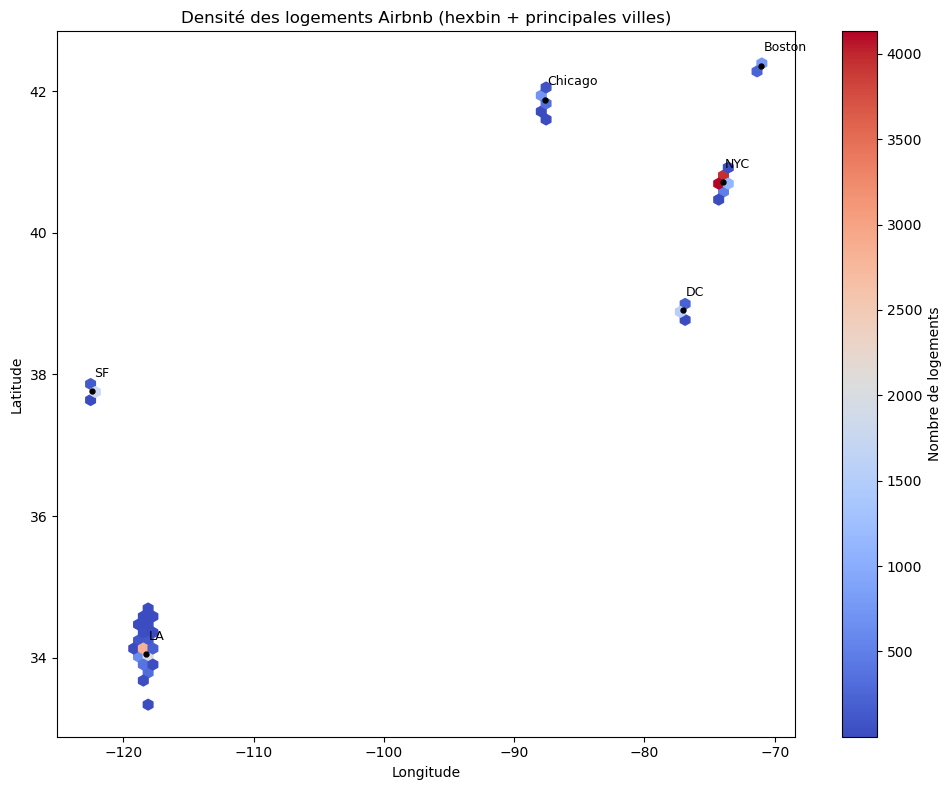

In [155]:
# Dictionnaire des principales villes et de leurs coordonnées
villes = {
    'LA': (-118.25, 34.05),
    'NYC': (-74.00, 40.71),
    'DC': (-77.04, 38.91),
    'SF': (-122.42, 37.77),
    'Chicago': (-87.63, 41.88),
    'Boston': (-71.06, 42.36)
}

plt.figure(figsize=(10,8))

# Hexbin plot classique
plt.hexbin(
    Donnee_Train['longitude'],
    Donnee_Train['latitude'],
    gridsize=70,
    cmap='coolwarm',
    mincnt=1
)
plt.colorbar(label='Nombre de logements')
plt.title("Densité des logements Airbnb (hexbin + principales villes)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Ajouter les points des villes
for ville, (lon, lat) in villes.items():
    plt.scatter(lon, lat, color='black', marker='.', s=50)  # Points noirs
    plt.text(lon + 0.2, lat + 0.2, ville, fontsize=9, color='black')  # Noms des villes

plt.tight_layout()
plt.show()


On remarque que il y a trois petites villes ( SF, DC, Boston) et trois plus grosses (Chicago, NYC, LA), Des villes ettendu comme LA et NYC presente un épicentre avec une tres forte densitée en logement. On remarque aussi que les villes on  une tendance a s'ettaller sur l'axe Nord-Sud mais moins en fonction de la Longitude.

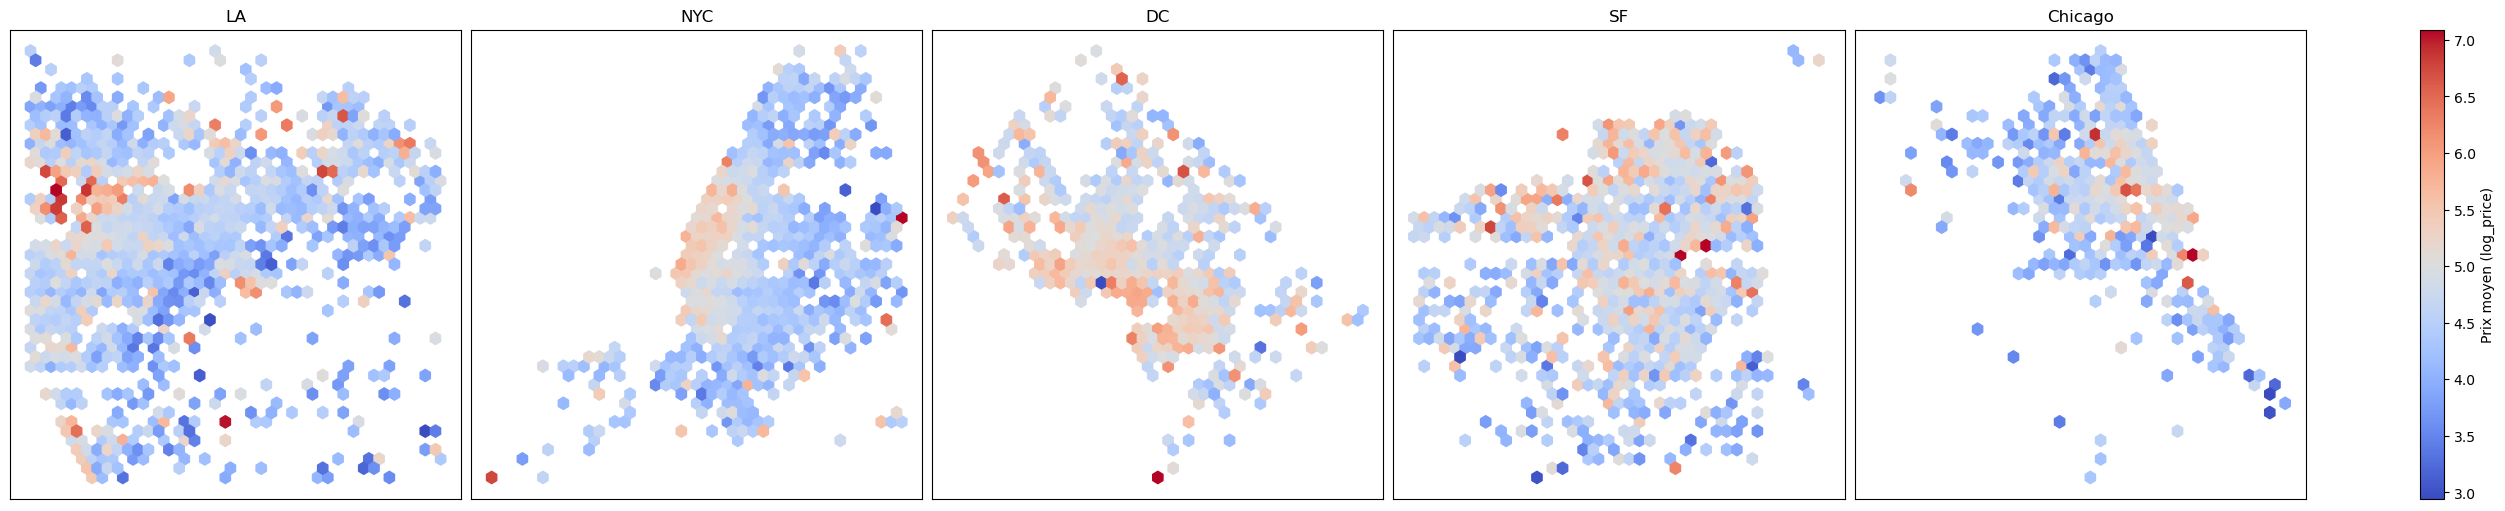

In [160]:
# Dictionnaire des principales villes avec leur centre (lon, lat) pour le zoom
villes = {
    'LA': (-118.25, 34.05),
    'NYC': (-74.00, 40.71),
    'DC': (-77.04, 38.91),
    'SF': (-122.42, 37.77),
    'Chicago': (-87.63, 41.88)
}

# Taille du zoom autour de chaque ville
zoom_lon = 0.2
zoom_lat = 0.2

# Créer une figure avec constrained layout pour éviter le warning
fig, axes = plt.subplots(1, 5, figsize=(25, 5), constrained_layout=True)

# Boucle sur les villes
for ax, (ville, (lon, lat)) in zip(axes, villes.items()):
    # Sous-échantillonnage local autour de la ville
    local_df = Donnee_Train[
        (Donnee_Train['longitude'] > lon - zoom_lon) & (Donnee_Train['longitude'] < lon + zoom_lon) &
        (Donnee_Train['latitude'] > lat - zoom_lat) & (Donnee_Train['latitude'] < lat + zoom_lat)
    ]
    
    # Hexbin sur la zone locale
    hb = ax.hexbin(
        local_df['longitude'],
        local_df['latitude'],
        C=local_df['log_price'],
        gridsize=40,
        cmap='coolwarm',
        reduce_C_function=np.mean,
        mincnt=1
    )
    ax.set_title(ville)
    
    # Masquer les ticks des axes
    ax.set_xticks([])
    ax.set_yticks([])

# Ajouter la colorbar pour l'ensemble
cbar = fig.colorbar(hb, ax=axes.ravel().tolist(), orientation='vertical', label='Prix moyen (log_price)')

plt.show()


Nous avons représenté la densité des logements et la répartition des prix (`log_price`) pour cinq grandes villes : **Los Angeles**, **New York**, **Washington DC**, **San Francisco** et **Chicago**.

Chaque graphique montre la densité des logements avec une couleur indiquant le **prix moyen** local :  
- **Rouge** : zones de logements plus chers,  
- **Bleu** : zones de logements moins chers.

On remarque plusieurs éléments intéressants :
- **À New York** et **San Francisco**, on observe des **zones très concentrées de logements chers**, surtout autour du centre-ville.
- **À Los Angeles**, la répartition est plus étalée, avec plusieurs "poches" de prix élevés dans différents quartiers.
- **À Washington DC** et **Chicago**, les prix sont globalement plus homogènes, avec quelques zones spécifiques plus haut de gamme.

Cette visualisation nous permet de comprendre que la **localisation géographique précise** a un **impact majeur sur le prix** d’un logement Airbnb.  
C’est donc une dimension importante à intégrer dans les futurs modèles de prédiction.

# Pretraitement des données 

Après avoir exploré et visualisé les variables les plus importantes, on a maintenant une bonne idée de celles qui influencent le prix (log_price) et de la manière dont elles se comportent. On va donc passer à la modification et transformation des variables pour préparer les données à l'entraînement de nos modèles.

Cette étape inclut le nettoyage, le traitement des valeurs manquantes, l’encodage des variables catégorielles et la création de nouvelles variables utiles. C’est une phase essentielle pour améliorer la performance des algorithmes.

In [178]:
# On travaille sur une copie pour pas casser l'original
Donnees = Donnee_Train.copy()

# Remplissage des colonnes numériques (par la médiane)
Donnees['bathrooms'] = Donnees['bathrooms'].fillna(Donnees['bathrooms'].median())
Donnees['bedrooms'] = Donnees['bedrooms'].fillna(Donnees['bedrooms'].median())
Donnees['beds'] = Donnees['beds'].fillna(Donnees['beds'].median())

# Note moyenne des avis → remplie avec la moyenne
Donnees['review_scores_rating'] = Donnees['review_scores_rating'].fillna(Donnees['review_scores_rating'].mean())

# Taux de réponse de l’hôte → on enlève le %, convertit en float, puis on met 0 si manquant
Donnees['host_response_rate'] = Donnees['host_response_rate'].str.rstrip('%').astype(float)
Donnees['host_response_rate'] = Donnees['host_response_rate'].fillna(0)

# Variables booléennes → t/f deviennent 1/0
Donnees['host_has_profile_pic'] = Donnees['host_has_profile_pic'].map({'t': 1, 'f': 0}).fillna(0)
Donnees['host_identity_verified'] = Donnees['host_identity_verified'].map({'t': 1, 'f': 0}).fillna(0)

# Ancienneté de l’hôte (on garde juste l’année)
Donnees['host_since'] = pd.to_datetime(Donnees['host_since'], errors='coerce')
Donnees['anciennete_host'] = Donnees['host_since'].apply(lambda d: 2025 - d.year if pd.notnull(d) else 0)
Donnees.drop(columns=['host_since'], inplace=True)

# Conversion des dates des reviews en nombre de jours depuis 01/01/2025
Donnees['first_review'] = pd.to_datetime(Donnees['first_review'], errors='coerce')
Donnees['last_review'] = pd.to_datetime(Donnees['last_review'], errors='coerce')
Donnees['jours_depuis_dernier_review'] = (pd.to_datetime("2025-01-01") - Donnees['last_review']).dt.days
Donnees['jours_depuis_premier_review'] = (pd.to_datetime("2025-01-01") - Donnees['first_review']).dt.days
Donnees['jours_depuis_dernier_review'] = Donnees['jours_depuis_dernier_review'].fillna(-1)
Donnees['jours_depuis_premier_review'] = Donnees['jours_depuis_premier_review'].fillna(-1)

# Pour le quartier et le code postal → on prend la valeur la plus fréquente
Donnees['neighbourhood'] = Donnees['neighbourhood'].fillna(Donnees['neighbourhood'].mode()[0])
Donnees['zipcode'] = Donnees['zipcode'].fillna(Donnees['zipcode'].mode()[0])


Suite à l’exploration réalisée précédemment, on a identifié plusieurs colonnes avec des valeurs manquantes ou des formats peu adaptés pour l’apprentissage automatique. Dans cette partie, on applique un nettoyage cohérent avec ce qu’on a observé.

Pour les variables numériques comme le nombre de chambres, de lits ou de salles de bain, on a choisi d’utiliser la médiane, car elle est moins sensible aux valeurs extrêmes. La note moyenne des avis a été complétée avec la moyenne, ce qui est logique étant donné sa distribution continue et régulière.

Le taux de réponse de l’hôte, qui était exprimé en pourcentage, a été transformé en valeur numérique puis complété par 0 lorsque l’information était absente, en considérant qu’un hôte sans données ne répond probablement pas. Pour les colonnes indiquant la présence d’une photo de profil ou une vérification d’identité, on a converti les valeurs textuelles en booléens, et les valeurs manquantes ont été considérées comme « non ».

On a également transformé la date d’inscription de l’hôte en une variable représentant son ancienneté en années, ce qui est plus simple et plus utile dans un modèle. De la même façon, les dates du premier et du dernier avis ont été converties en nombre de jours écoulés depuis une date de référence (01/01/2025), afin de garder une information temporelle pertinente.

Enfin, pour les colonnes textuelles comme le quartier ou le code postal, on a complété les valeurs manquantes avec la modalité la plus fréquente, ce qui permet de conserver l’information sans introduire de biais important.

# Transformation de variable

commencons par la variable "amenities"

In [183]:
def extract_amenities(amenity_string):
    try:
        amenity_string = amenity_string.strip('{}')
        items = [a.strip().strip('"') for a in amenity_string.split(',')]
        return items
    except:
        return []

Donnees['parsed_amenities'] = Donnees['amenities'].apply(extract_amenities)

# On rassemble tous les équipements et on compte combien de fois ils apparaissent
all_amenities = Donnees['parsed_amenities'].explode()
amenity_counts = all_amenities.value_counts()

#les 20 équipements les plus fréquents pour nos predictions 
top_amenities = amenity_counts.head(20)


In [185]:
# Création d'une colonne 0/1 pour chaque équipement du top 20
for equipement in top_amenities.index:
    col_name = f'amenity_{equipement}'
    Donnees[col_name] = Donnees['parsed_amenities'].apply(lambda x: int(equipement in x))

# (optionnel) Aperçu du résultat avec les nouvelles colonnes créées
Donnees[[f'amenity_{e}' for e in top_amenities.index]].head()


,amenity_Wireless Internet,amenity_Kitchen,amenity_Heating,amenity_Essentials,amenity_Smoke detector,amenity_Air conditioning,amenity_TV,amenity_Shampoo,amenity_Hangers,amenity_Carbon monoxide detector,amenity_Internet,amenity_Laptop friendly workspace,amenity_Washer,amenity_Hair dryer,amenity_Dryer,amenity_Iron,amenity_Family/kid friendly,amenity_Fire extinguisher,amenity_First aid kit,amenity_translation missing: en.hosting_amenity_50
0,1,1,0,1,1,0,1,1,1,0,0,0,1,1,1,1,0,0,0,0
1,1,1,1,1,1,1,0,0,0,1,0,0,0,1,0,1,1,1,0,1
2,1,1,1,1,1,1,1,1,0,1,0,1,1,0,1,0,1,1,1,0
3,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,1
4,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0


La colonne amenities, c’est juste une grosse chaîne de texte avec tous les équipements dispo dans un logement. Sauf que pour un modèle de machine learning, ça ne sert à rien dans ce format. Du coup, on a commencé par transformer cette chaîne en vraie liste, histoire de pouvoir bosser dessus proprement.

Ensuite, on a regardé quels équipements revenaient le plus souvent dans les logements. On en a gardé les 20 les plus fréquents, car ce sont sûrement ceux qui ont le plus d’impact sur le prix (genre Wi-Fi, cuisine, clim…).

Pour finir, on a créé une nouvelle colonne pour chaque équipement, où on met 1 si le logement l’a, et 0 sinon. Comme ça, on garde un max d’info utile, mais sous une forme claire et exploitable par nos modèles.



Passons a "longitude" et "latitude" : 

In [189]:
from sklearn.cluster import KMeans

# On récupère les colonnes latitude et longitude
coordonnees = Donnees[['latitude', 'longitude']]

# On applique un clustering simple pour diviser les logements en 5 zones
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
Donnees['zone_geo'] = kmeans.fit_predict(coordonnees)

# Résultat : chaque logement est assigné à une "zone géographique"
Donnees[['latitude', 'longitude', 'zone_geo']].head()


,latitude,longitude,zone_geo
0,33.782712,-118.134410,3
1,40.705468,-73.909439,1
2,38.917537,-77.031651,4
3,40.736001,-73.924248,1
4,37.744896,-122.430665,0


En cherchant un peu ce qu'il etait possible de faire avec une longitude et une latitude on a trouvé la possibilité de faire des agreagation en zone geographique , pour pouvoir garder ces variables qui semble quand meme assez importante d'un point de vue général, on a vu dans la heatmap dans la partie exploration que la latitude et la longitude ont une grosse corrélation donc on aurait pu en garder qu'une des deux, mais en ayant trouver cette methode nous avons fait le choix de reunir les 2 dans cette nouvelle variable "zone_geo" 

Le nombre de chambres, de lits ou de salles de bain est utile, mais ce qui compte vraiment pour un voyageur, c’est l’espace ou le confort disponible par personne. Par exemple, un logement avec 3 lits pour 2 personnes n’a pas le même standing qu’un autre avec 3 lits pour 6 personnes.

Pour mieux représenter cette idée, on va donc créer quelques ratios simples : nombre de chambres par personne, nombre de lits par personne, et nombre de salles de bain par personne. Ces nouvelles variables peuvent aider les modèles à mieux comprendre le niveau de confort offert par chaque logement.



In [193]:
# on s'assure qu'on ne divise jamais par zéro ( au debut on avait pas mis cette ligne et ca marchait pas bien ) 
Donnees['accommodates'] = Donnees['accommodates'].replace(0, 1)

# au cas ou les variables soient incomplètes
Donnees['bathrooms'] = Donnees['bathrooms'].fillna(Donnees['bathrooms'].median())
Donnees['bedrooms'] = Donnees['bedrooms'].fillna(Donnees['bedrooms'].median())
Donnees['beds'] = Donnees['beds'].fillna(Donnees['beds'].median())

# Création des ratios comme dans le TD1
Donnees['ratio_chambres_pers'] = Donnees['bedrooms'] / Donnees['accommodates']
Donnees['ratio_lits_pers'] = Donnees['beds'] / Donnees['accommodates']
Donnees['ratio_sdb_pers'] = Donnees['bathrooms'] / Donnees['accommodates']

Donnees[['ratio_chambres_pers', 'ratio_lits_pers', 'ratio_sdb_pers']].head()


,ratio_chambres_pers,ratio_lits_pers,ratio_sdb_pers
0,0.000000,0.666667,0.333333
1,0.250000,0.500000,0.500000
2,0.333333,0.333333,0.333333
3,1.000000,1.000000,1.000000
4,0.500000,0.500000,0.250000


Regardons desormais la variable " description " : 

La description d’un logement peut contenir des infos très utiles sur le style ou la qualité de l’appartement, mais comme c’est du texte brut, ce n’est pas exploitable directement. Plutôt que de tout analyser en détail (ce qui serait long), on a décidé de repérer simplement certains mots-clés fréquents comme “luxury”, “cozy” ou “central”.

Pour la selection des mots on a regarder a la main quelques mots, mais cette liste est evolutive...

On a donc créé une colonne binaire pour chaque mot-clé, avec 1 si le mot est présent dans la description, et 0 sinon. Ça permet de capturer des éléments subjectifs ou marketing qui peuvent influencer le prix, sans passer par des méthodes de traitement de texte avancées.

In [197]:
# On remplace les valeurs manquantes par une chaîne vide pour éviter les erreurs 
# au debut on avait des erreurs donc on a mis des chaines vide, on a aussi essayer avec 
# un mot "commum" a tous les logements mais c'etait non concluant. 
Donnees['description'] = Donnees['description'].fillna("")

mots_cles = ['luxury', 'cozy', 'modern', 'spacious', 'central', 'downtown', 'quiet', 'comfortable']

for mot in mots_cles:
    Donnees[f'desc_has_{mot}'] = Donnees['description'].str.lower().str.contains(mot).astype(int)


#Donnees[[f'desc_has_{mot}' for mot in mots_cles]].head()


Et pour le code postal ?  

Le code postal donne une indication sur la localisation du logement, mais comme il y a beaucoup de valeurs différentes, l’encoder directement n’apporte pas grand-chose. Pour en tirer une info utile, on a calculé le prix moyen observé pour chaque code postal, puis on a créé une nouvelle colonne (prix_moyen_zip) qui associe ce prix moyen à chaque logement.

On pourrait penser que ça fait doublon avec la variable zone_geo qu’on a créée plus tôt avec KMeans, mais en réalité les deux se complètent bien. zone_geo classe les logements par proximité géographique, sans connaître les prix. prix_moyen_zip, lui, se base uniquement sur les prix réellement observés dans les données. L’un donne une info spatiale, l’autre une info économique.

En combinant les deux, on donne au modèle à la fois l’emplacement général du logement et le niveau de prix moyen autour, ce qui est très pertinent pour la prédiction.

In [201]:
#toujours pareil si on rempli pas les na alors ca marche pas bien 
Donnees['zipcode'] = Donnees['zipcode'].fillna(Donnees['zipcode'].mode()[0])

# On calcule le prix moyen !! attention !!  on le fait par code postal
prix_moyen_par_zip = Donnees.groupby('zipcode')['log_price'].mean()


Donnees['prix_moyen_zip'] = Donnees['zipcode'].map(prix_moyen_par_zip)


#Donnees[['zipcode', 'prix_moyen_zip']].head()


Et on va terminer par le quartier ! 

Comme pour le code postal juste avant , le quartier (neighbourhood) peut donner une indication sur la localisation du logement. Mais là encore, il y a trop de catégories différentes, et certaines n’apparaissent que quelques fois.

Au lieu de les encoder toutes, on a décidé de se concentrer sur les quartiers les plus représentés dans le dataset. On a donc créé une nouvelle colonne quartier_top qui vaut 1 si le logement se trouve dans l’un des 15 quartiers les plus fréquents, et 0 sinon. Cela permet de garder une information sur les zones "actives", sans trop complexifier les données.  

on avait essayer une autre methode pour garder plus d'information sur le quartier mais c'etait trop de complexe pour nous a gerer dans l'encodage par la suite ! 

In [205]:
# idem que au dessus pour eviter les erreurs
Donnees['neighbourhood'] = Donnees['neighbourhood'].fillna(Donnees['neighbourhood'].mode()[0])

# On récupère les 15 quartiers les plus présents
top_neighbourhoods = Donnees['neighbourhood'].value_counts().head(15)

#et la methode en elle meme pour recup des 0 et des 1 
Donnees['quartier_top'] = Donnees['neighbourhood'].apply(lambda x: 1 if x in top_neighbourhoods.index else 0)



# Suppression des données inutiles 

In [208]:
colonnes_a_supprimer = [
    'amenities', 'description', 'zipcode', 'neighbourhood',
    'name', 'first_review', 'last_review']


Donnees.drop(columns=colonnes_a_supprimer, inplace=True)



Après toutes nos transformations, certaines colonnes ne sont plus utiles dans leur format d’origine. Par exemple, on a extrait des équipements à partir de amenities, repéré des mots-clés dans description, et transformé zipcode ou neighbourhood en variables numériques ou binaires.

Du coup, on peut maintenant supprimer ces colonnes pour ne garder que les variables vraiment exploitables pour l'entraînement du modèle.

# Encodage 

Maintenant que toutes nos variables ont été nettoyées et enrichies grâce au feature engineering, on termine par un encodage final des dernières variables catégorielles restantes. On utilise un One-Hot Encoding pour les convertir en colonnes binaires exploitables par les modèles. On s’assure ainsi que notre jeu de données est entièrement numérique et prêt pour l’entraînement.

Pour que les modèles de machine learning puissent traiter les variables catégorielles restantes (comme certains types de zones ou labels), on utilise la fonction get_dummies() de la bibliothèque Pandas. Cette fonction permet de transformer une colonne contenant des catégories textuelles en plusieurs colonnes binaires (0 ou 1), ce qu'on appelle aussi un encodage One-Hot.

Par exemple, si une colonne contient trois valeurs : A, B et C, get_dummies() va créer deux colonnes : is_B et is_C. Si une ligne vaut A, alors les deux colonnes auront la valeur 0. On ne garde que n-1 colonnes grâce au paramètre drop_first=True pour éviter la redondance (multicolinéarité) dans certains modèles comme la régression linéaire.

On a choisi cette méthode car elle est simple, intégrée dans Pandas, et surtout recommandée dans la documentation officielle (pandas.pydata.org) pour l'encodage des variables catégorielles quand on utilise des algorithmes qui ne gèrent pas directement les textes ou les labels.

In [214]:
# Suppression des colonnes problématiques (texte, inutiles ou déjà traitées)
colonnes_a_supprimer_si_existent = ['parsed_amenities', 'amenities', 'host_since', 'description']
for col in colonnes_a_supprimer_si_existent:
    if col in Donnees.columns:
        Donnees.drop(columns=col, inplace=True)

# On identifie les colonnes catégorielles
colonnes_object = Donnees.select_dtypes(include='object').columns.tolist()

# On garde uniquement celles avec un nombre de modalités raisonnable (ex: < 200)
colonnes_object_filtrees = [
    col for col in colonnes_object if Donnees[col].nunique() < 200
]

# Encodage final des colonnes catégorielles filtrées
Donnees_encoded = pd.get_dummies(Donnees, columns=colonnes_object_filtrees, drop_first=True)

# Vérification
Donnees_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 100 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   id                                                  22234 non-null  int64  
 1   log_price                                           22234 non-null  float64
 2   accommodates                                        22234 non-null  int64  
 3   bathrooms                                           22234 non-null  float64
 4   cleaning_fee                                        22234 non-null  bool   
 5   host_has_profile_pic                                22234 non-null  float64
 6   host_identity_verified                              22234 non-null  float64
 7   host_response_rate                                  22234 non-null  float64
 8   latitude                                            22234 non-null  float64

# modelisation

Avant de tester des modèles plus complexes, on commence par une régression linéaire simple pour poser une première baseline. Ce modèle est rapide à entraîner et permet de voir si nos variables ont déjà un pouvoir prédictif.

On sépare d’abord les données en deux parties : 80 % pour l’entraînement, et 20 % pour le test. On évalue ensuite la performance avec la RMSE (Root Mean Squared Error), qui donne une idée de l’écart moyen entre les prédictions du modèle et les vraies valeurs.

In [218]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Séparation des variables explicatives et de la cible
X = Donnees_encoded.drop(columns=['log_price'])
y = Donnees_encoded['log_price']

# Division des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation du modèle avec la RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE (Régression linéaire) : {rmse:.4f}")


RMSE (Régression linéaire) : 0.4060


In [220]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# On suppose que Donnees_encoded existe déjà dans le notebook
X = Donnees_encoded.drop(columns=['log_price'])
y = Donnees_encoded['log_price']

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèles à tester
modeles = {
    "Régression linéaire": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Arbre de décision": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Liste pour stocker les résultats
resultats = []

# Entraînement + prédiction + évaluation pour chaque modèle
for nom, modele in modeles.items():
    modele.fit(X_train, y_train)
    y_pred = modele.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    resultats.append({
        'Modèle': nom,
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'R²': round(r2, 4)
    })

# Affichage des résultats
df_resultats = pd.DataFrame(resultats).sort_values(by='RMSE')
print(df_resultats)


C:\Users\ebeni\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.01416e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


                Modèle    RMSE     MAE      R²
5    Gradient Boosting  0.3958  0.2865  0.6942
4        Random Forest  0.3993  0.2865  0.6887
0  Régression linéaire  0.4060  0.2930  0.6782
1                Ridge  0.4060  0.2930  0.6783
3    Arbre de décision  0.5872  0.4218  0.3270
2                Lasso  0.7106  0.5577  0.0144


# Rajout de variable

nous avons décidé de rajouter des variables car les resultats n'etait pas assez concluant selon nous 

In [102]:
# Recharger uniquement la colonne 'amenities' depuis le CSV d'origine
original_df = pd.read_csv("airbnb_train.csv", usecols=['id', 'amenities'])

# Fusionner avec le DataFrame actuel (Donnees) via la colonne 'id'
Donnees = Donnees.merge(original_df, on='id', how='left')

# Reparser les équipements en liste
def extract_amenities(amenity_string):
    try:
        amenity_string = amenity_string.strip('{}')
        items = [a.strip().strip('"') for a in amenity_string.split(',')]
        return items
    except:
        return []

Donnees['parsed_amenities'] = Donnees['amenities'].apply(extract_amenities)

# Créer la nouvelle feature : nombre total d’équipements
Donnees['nb_equipements_total'] = Donnees['parsed_amenities'].apply(len)

# Aperçu
Donnees[['id', 'nb_equipements_total', 'parsed_amenities']].head()

,id,nb_equipements_total,parsed_amenities
0,5708593,15,"[TV, Wireless Internet, Kitchen, Free parking ..."
1,14483613,25,"[Wireless Internet, Air conditioning, Kitchen,..."
2,10412649,20,"[TV, Wireless Internet, Air conditioning, Kitc..."
3,17954362,30,"[TV, Cable TV, Internet, Wireless Internet, Ai..."
4,9969781,24,"[TV, Cable TV, Internet, Wireless Internet, Ki..."


La colonne amenities contient une liste d’équipements pour chaque logement, mais sous forme de texte brut, donc pas exploitable directement.
On a d’abord rechargé cette colonne depuis le fichier CSV d’origine, puis on l’a transformée en vraie liste Python à l’aide d’une petite fonction.

Ensuite, on a créé une nouvelle variable nb_equipements_total qui compte le nombre total d’équipements différents pour chaque logement.
Cela nous permet d’avoir une indication du niveau d’équipement global de chaque annonce, ce qui peut clairement influencer le prix. 



In [140]:
# Calcul du prix moyen par zone déjà existante
prix_moyen_par_zone = Donnees.groupby('zone_geo')['log_price'].mean()
Donnees['prix_moyen_zone_geo'] = Donnees['zone_geo'].map(prix_moyen_par_zone)

Puisqu'on a déjà regroupé les logements en zones géographiques (zone_geo), on va maintenant calculer le prix moyen dans chaque zone .

On ajoute cette information dans une nouvelle variable "prix_moyen_zone_geo". Cela aide notre modèle à comprendre les différences de niveau de prix entre les zones, sans avoir besoin de connaître précisément les quartiers.

In [107]:
# Si la colonne 'amenities' n'existe plus, on la recharge depuis le fichier original
if 'amenities' not in Donnees.columns:
    original_df = pd.read_csv("airbnb_train.csv", usecols=['id', 'amenities'])
    Donnees = Donnees.merge(original_df, on='id', how='left')

# On transforme la chaîne de caractères en vraie liste d'équipements
def extract_amenities(amenity_string):
    try:
        amenity_string = amenity_string.strip('{}')
        items = [a.strip().strip('"') for a in amenity_string.split(',')]
        return items
    except:
        return []

Donnees['parsed_amenities'] = Donnees['amenities'].apply(extract_amenities)

# On calcule le nombre total d'équipements listés pour chaque logement
Donnees['nb_equipements_total'] = Donnees['parsed_amenities'].apply(len)

# On évite la division par zéro en remplaçant 0 par 1
Donnees['accommodates'] = Donnees['accommodates'].replace(0, 1)

# On calcule le ratio équipements / personnes
Donnees['equipement_par_pers'] = Donnees['nb_equipements_total'] / Donnees['accommodates']

# Aperçu
Donnees[['nb_equipements_total', 'accommodates', 'equipement_par_pers']].head()

,nb_equipements_total,accommodates,equipement_par_pers
0,15,3,5.000000
1,25,4,6.250000
2,20,6,3.333333
3,30,1,30.000000
4,24,4,6.000000


Après avoir extrait la liste complète des équipements pour chaque logement (à partir de la colonne amenities), on a compté le nombre total d’équipements dans une nouvelle variable : nb_equipements_total.

Mais on s’est dit que le nombre seul n'était pas suffisant. Un logement avec 10 équipements pour 10 personnes n’a pas le même confort qu’un logement avec 10 équipements pour 2 personnes.

Du coup, on a créé une nouvelle variable plus pertinente : equipement_par_pers, qui correspond au ratio entre le nombre d’équipements et le nombre de personnes que le logement peut accueillir.
Cela nous donne une idée plus juste du niveau de confort par personne.

On a aussi sécurisé la division en remplaçant les éventuels 0 dans accommodates par 1, pour éviter les erreurs de calcul.

In [109]:

# On s'assure que les coordonnées sont bien présentes et sans NaN
Donnees['latitude'] = Donnees['latitude'].fillna(Donnees['latitude'].median())
Donnees['longitude'] = Donnees['longitude'].fillna(Donnees['longitude'].median())

# On calcule le centre géographique (moyenne des latitudes et longitudes)
centre_lat = Donnees['latitude'].mean()
centre_long = Donnees['longitude'].mean()

# On calcule la "distance" entre chaque logement et ce centre (distance euclidienne simplifiée)
Donnees['distance_au_centre'] = np.sqrt(
    (Donnees['latitude'] - centre_lat)**2 + (Donnees['longitude'] - centre_long)**2
)

# Aperçu
Donnees[['latitude', 'longitude', 'distance_au_centre']].head()

,latitude,longitude,distance_au_centre
0,33.782712,-118.134410,26.285139
1,40.705468,-73.909439,18.496309
2,38.917537,-77.031651,15.244432
3,40.736001,-73.924248,18.485340
4,37.744896,-122.430665,30.169907


La localisation joue un rôle très important dans le prix d’un logement. Pour avoir une mesure simple de l’emplacement, on a calculé la distance de chaque logement par rapport au centre géographique de tous les logements du dataset.

On a d’abord vérifié que les coordonnées (latitude, longitude) ne contiennent pas de valeurs manquantes, puis on a calculé la distance euclidienne entre chaque logement et le "centre" (défini comme la moyenne des coordonnées).

Même si ce n’est pas une distance exacte (pas de projection géographique ici), ça donne une bonne estimation de si le logement est proche ou loin du centre de la zone étudiée.

In [111]:
# Si nécessaire, on recharge host_since depuis le fichier original
if 'host_since' not in Donnees.columns:
    original_df = pd.read_csv("airbnb_train.csv", usecols=['id', 'host_since'])
    Donnees = Donnees.merge(original_df, on='id', how='left')

# On transforme en datetime et calcule l'ancienneté
Donnees['host_since'] = pd.to_datetime(Donnees['host_since'], errors='coerce')
Donnees['anciennete_host'] = Donnees['host_since'].apply(lambda d: 2025 - d.year if pd.notnull(d) else 0)

# Création de la variable host_expert
Donnees['host_expert'] = (
    (Donnees['anciennete_host'] > 5) &
    (Donnees['host_has_profile_pic'] == 1) &
    (Donnees['host_identity_verified'] == 1)
).astype(int)

# Aperçu
Donnees[['anciennete_host', 'host_has_profile_pic', 'host_identity_verified', 'host_expert']].head()

,anciennete_host,host_has_profile_pic,host_identity_verified,host_expert
0,10,1.0,0.0,0
1,9,1.0,1.0,1
2,9,1.0,0.0,0
3,13,1.0,1.0,1
4,12,1.0,1.0,1


Pour cette partie, on s’est intéressés au profil de l’hôte, en particulier à son ancienneté. L’idée était de savoir si un hôte expérimenté pouvait avoir un impact sur le prix du logement. On a donc commencé par recharger la date d’inscription (host_since), puis on a transformé cette information en une variable numérique qui indique l’ancienneté de l’hôte en années.

À partir de ça, on a créé une nouvelle variable qu’on a appelée host_expert. Elle vaut 1 si l’hôte est inscrit depuis plus de 5 ans, qu’il a une photo de profil et que son identité est vérifiée. Sinon, elle vaut 0. Cette variable nous permet de détecter les hôtes les plus "pro", qui peuvent proposer des logements mieux notés ou plus attractifs, donc potentiellement plus chers.

In [129]:
# Nettoyage avant l'encodage
colonnes_a_supprimer_si_existent = [
    'parsed_amenities', 'amenities', 'host_since', 'description',
    'first_review', 'last_review', 'amenities_x', 'amenities_y', 'name'
]

for col in colonnes_a_supprimer_si_existent:
    if col in Donnees.columns:
        Donnees.drop(columns=col, inplace=True)

#Sélection des colonnes catégorielles de type "object"
colonnes_object = Donnees.select_dtypes(include='object').columns.tolist()

# On garde uniquement celles avec peu de modalités pour éviter explosion mémoire
colonnes_object_filtrees = [
    col for col in colonnes_object if Donnees[col].nunique() < 200
]

# Encodage final avec get_dummies
Donnees_encoded = pd.get_dummies(Donnees, columns=colonnes_object_filtrees, drop_first=True)

#Vérification
print("Dimensions du jeu de données encodé :", Donnees_encoded.shape)
print("Types de données présents :", Donnees_encoded.dtypes.value_counts())


Dimensions du jeu de données encodé : (22234, 105)
Types de données présents : bool       50
int64      35
float64    19
int32       1
Name: count, dtype: int64


# Nouvelle prediction

In [131]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# On nettoie X avant d'entraîner
X = Donnees_encoded.drop(columns=['log_price'], errors='ignore')

# Suppression des colonnes interdites par XGBoost (type object, ici amenities)
colonnes_obj = X.select_dtypes(include='object').columns.tolist()
X = X.drop(columns=colonnes_obj)

# Target
y = Donnees_encoded['log_price']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configurations XGBoost à tester
configs = [
    {"n_estimators": 100, "max_depth": 3, "learning_rate": 0.1},
    {"n_estimators": 200, "max_depth": 5, "learning_rate": 0.05},
    {"n_estimators": 300, "max_depth": 7, "learning_rate": 0.1},
    {"n_estimators": 100, "max_depth": 6, "learning_rate": 0.05}
]

# Résultats
results = []

for config in configs:
    model = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        verbosity=0,
        **config
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "n_estimators": config["n_estimators"],
        "max_depth": config["max_depth"],
        "learning_rate": config["learning_rate"],
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4),
        "R²": round(r2, 4)
    })

# Affichage
df_xgb_results = pd.DataFrame(results).sort_values(by="RMSE")
print(df_xgb_results)


   n_estimators  max_depth  learning_rate    RMSE     MAE      R²
2           300          7           0.10  0.3872  0.2771  0.7073
1           200          5           0.05  0.3889  0.2793  0.7048
3           100          6           0.05  0.3917  0.2822  0.7005
0           100          3           0.10  0.3957  0.2859  0.6943


In [137]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# On recrée X et y sur toutes les données
X_full = Donnees_encoded.drop(columns=['log_price']).copy()
y_full = Donnees_encoded['log_price']

# 🔍 Suppression des colonnes de type "object" non compatibles avec XGBoost
colonnes_object = X_full.select_dtypes(include='object').columns.tolist()
X_full = X_full.drop(columns=colonnes_object)

# Entraînement final du meilleur modèle
model_final = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=320,
    max_depth=7,
    learning_rate=0.10,
    random_state=42,
    verbosity=0
)

model_final.fit(X_full, y_full)

# Prédictions sur le même jeu de données
y_full_pred = model_final.predict(X_full)

# Évaluation (interne, à ne pas confondre avec validation)
rmse = np.sqrt(mean_squared_error(y_full, y_full_pred))
mae = mean_absolute_error(y_full, y_full_pred)
r2 = r2_score(y_full, y_full_pred)

# Affichage des résultats
print("Entraîné sur 100% des données")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")


Entraîné sur 100% des données
RMSE : 0.2210
MAE  : 0.1615
R²   : 0.9054


In [ ]:
# Prédiction complète sur X_full
y_final_pred = model_final.predict(X_full)

# Création d’un DataFrame avec l’ID (ou index) et les prédictions
predictions_df = pd.DataFrame({
    "id": Donnees_encoded["id"] if "id" in Donnees_encoded.columns else np.arange(len(y_final_pred)),
    "log_price_pred": y_final_pred
})

# Export du fichier CSV
predictions_df.to_csv("predictions_finales_xgboost.csv", index=False)
